In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Ice Cream Production Data

In [32]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [36]:
# read data
production_ice_cream = pd.read_csv('Sample Data/ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True)
# Description :
# 데이터의 첫 번째 column이 날짜형이며, index로 지정함

production_ice_cream.head()

/var/folders/nc/lzp_t3zn1m5_9jr25f_8fqj00000gn/T/ipykernel_5586/2252931733.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  production_ice_cream = pd.read_csv('Sample Data/ice_cream.csv', parse_dates=[0], index_col=0, squeeze=True)


DATE
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636
Name: IPN31152N, dtype: float64

In [38]:
production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [39]:
# infer the frequenrcy of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [40]:
# just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

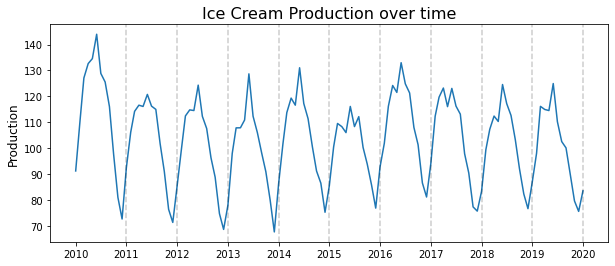

In [42]:
plt.figure(figsize=(10, 4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production over time', fontsize=16)
plt.ylabel('Production', fontsize=12)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

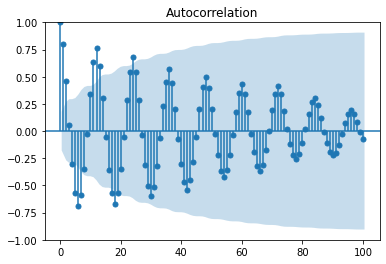

In [45]:
acf_plot = plot_acf(production_ice_cream, lags=100)

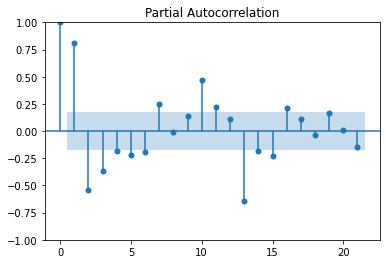

In [47]:
pacf_plot = plot_pacf(production_ice_cream)

## Based on PACF, we should start with an Auto Regressive model with lags 1, 2, 3

In [48]:
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [55]:
# create the model
model = ARIMA(train_data, order=(3, 0, 0))

In [56]:
# fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)
# start, end 통해서 모델 fitting에 소요되는 시간 확인
# AR 차수가 높아질 수록, 모델의 복잡도가 늘어나기 때문에 더 많은 시간 소요

Model Fitting Time: 0.1157841682434082


In [57]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Fri, 14 Jul 2023   AIC                            758.170
Time:                        08:53:33   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [59]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [60]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0.5, 1.0, 'Residuals from AR Model')

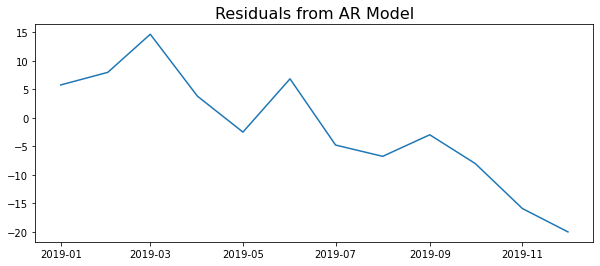

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=16)

Text(0, 0.5, 'Production')

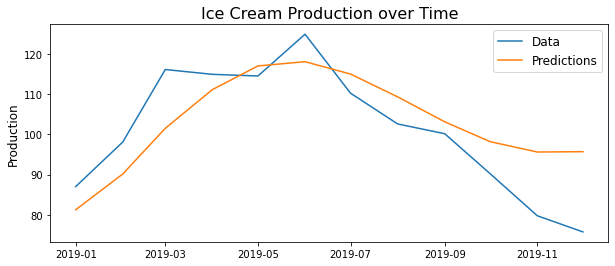

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=12)
plt.title('Ice Cream Production over Time', fontsize=16)
plt.ylabel('Production', fontsize=12)

In [64]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)), 4))

Mean Absolute Percent Error: 0.0895


In [65]:
print('Root Mean Squrared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squrared Error: 9.884158745209978
